In [27]:
import seaborn as sns
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D,Dropout

In [28]:
path = "homer_bart_2/"

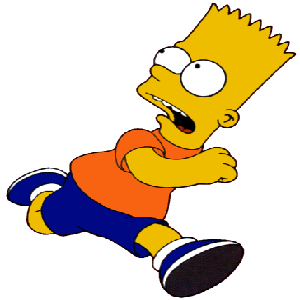

In [29]:
load_img("homer_bart_2/training_set/bart/bart100.bmp",target_size=(300,300))

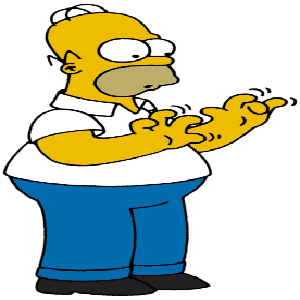

In [30]:
load_img("homer_bart_2/training_set/homer/homer100.bmp",target_size=(300,300))

In [31]:
training_generator = ImageDataGenerator(rescale=1./255,
                                        rotation_range=7,
                                        horizontal_flip=True,
                                        zoom_range=0.2)
train_dataset = training_generator.flow_from_directory(f"{path}/training_set",
                                                       target_size = (256,256),
                                                       batch_size=8,
                                                       class_mode="categorical",
                                                       shuffle=True)

Found 215 images belonging to 2 classes.


In [32]:
test_generator = ImageDataGenerator(rescale=1./255)
test_dataset = test_generator.flow_from_directory(f"{path}/test_set",
                                                       target_size = (256,256),
                                                       batch_size=1,
                                                       class_mode="categorical",
                                                       shuffle=False)

Found 54 images belonging to 2 classes.


#### Pre-trained Network: ResNet

In [33]:
resnet50 = tf.keras.applications.ResNet50(weights="imagenet",
                                          include_top=False,
                                          input_tensor = Input(shape=(256,256,3)))
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [34]:
# for layer in resnet50.layers:
#     layer.trainable=False

In [35]:
model = resnet50.output
model = GlobalAveragePooling2D()(model)
model = Dense(units=1025,activation="relu")(model)
model = Dropout(rate=0.2)(model)
model = Dense(units=1025,activation="relu")(model)
model = Dropout(rate=0.2)(model)
model = Dense(2,activation="softmax")(model)

In [36]:
cnn = Model(inputs=resnet50.input,outputs=model)
cnn.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [37]:
cnn.compile(optimizer="Adam",
            loss="categorical_crossentropy",
            metrics=["accuracy"])

In [40]:
h = cnn.fit(train_dataset,epochs=3)

Epoch 1/3
27/27 [==============================] - 90s 3s/step - loss: 0.8227 - accuracy: 0.6791
Epoch 2/3
27/27 [==============================] - 69s 3s/step - loss: 0.7649 - accuracy: 0.6930
Epoch 3/3
27/27 [==============================] - 68s 3s/step - loss: 0.5019 - accuracy: 0.8233


In [41]:
predictions = cnn.predict(test_dataset)
predictions = np.argmax(predictions,axis=1)

In [42]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

accuracy_score(test_dataset.classes,predictions)

0.48148148148148145

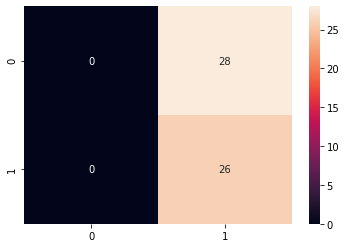

In [43]:
cm = confusion_matrix(test_dataset.classes,predictions)
sns.heatmap(cm,annot=True);

In [16]:
# print(classification_report(test_dataset.classes,predictions))

In [17]:
fine_tuning_at = 140
for layer in resnet50.layers[:fine_tuning_at]:
    layer.trainable = False

In [18]:
cnn.compile(optimizer="Adam",
            loss="categorical_crossentropy",
            metrics=["accuracy"])

In [19]:
h = cnn.fit(train_dataset,epochs=10)

Epoch 1/10
27/27 [==============================] - 30s 972ms/step - loss: 0.8077 - accuracy: 0.5814
Epoch 2/10
27/27 [==============================] - 29s 1s/step - loss: 0.6627 - accuracy: 0.6186
Epoch 3/10
27/27 [==============================] - 30s 1s/step - loss: 0.5955 - accuracy: 0.6651
Epoch 4/10
27/27 [==============================] - 34s 1s/step - loss: 0.5855 - accuracy: 0.7116
Epoch 5/10
27/27 [==============================] - 34s 1s/step - loss: 0.6363 - accuracy: 0.6791
Epoch 6/10
27/27 [==============================] - 29s 1s/step - loss: 0.6263 - accuracy: 0.6233
Epoch 7/10
27/27 [==============================] - 28s 1s/step - loss: 0.5691 - accuracy: 0.7628
Epoch 8/10
27/27 [==============================] - 30s 1s/step - loss: 0.6105 - accuracy: 0.6791
Epoch 9/10
27/27 [==============================] - 29s 1s/step - loss: 0.5533 - accuracy: 0.6837
Epoch 10/10
27/27 [==============================] - 28s 1s/step - loss: 0.5708 - accuracy: 0.7395


In [20]:
predictions = cnn.predict(test_dataset)
predictions = np.argmax(predictions,axis=1)

In [21]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

accuracy_score(test_dataset.classes,predictions)

0.48148148148148145

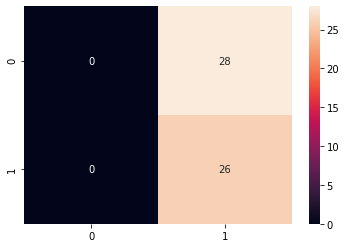

In [22]:
cm = confusion_matrix(test_dataset.classes,predictions)
sns.heatmap(cm,annot=True);

In [23]:
# cnn.save("models/cnn_homer_bart_tl.h5")

/Users/wine/opt/miniconda3/envs/ds_env/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [24]:
loaded_model = load_model("models/cnn_homer_bart_tl.h5")
predictions = loaded_model.predict(test_dataset)
predictions = np.argmax(predictions,axis=1)
accuracy_score(test_dataset.classes,predictions)

0.48148148148148145

In [25]:
image = cv2.imread(f"{path}/test_set/homer/homer10.bmp")
image = cv2.resize(image,(256,256))
image = image/255
image = image.reshape(1,256,256,3)
result = cnn.predict(image)
result = np.argmax(result,axis=1)
result[0]

1

In [26]:
train_dataset.class_indices

{'bart': 0, 'homer': 1}